In [1]:
pip install langchain_community langchain faiss-cpu pymupdf Pillow langchain_openai langchain_core pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 6.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 6.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: openai
    Found existing installation: openai 1.42.0
    Uninstalling openai-1.42.0:
      Successfully uninstalled openai-1.42.0

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import dotenv
import os
from openai import OpenAI
import numpy as np
import faiss
import base64
import io
import fitz
from PIL import Image
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from nltk.tokenize import sent_tokenize  # Import the sentence tokenizer

In [41]:
pip install -U :class:~langchain-openai

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: ':class:~langchain-openai': Expected package name at the start of dependency specifier
    :class:~langchain-openai
    ^


In [3]:
# load enviorment variables
dotenv.load_dotenv()

True

In [195]:
class Reader_10K:
    def __init__(self, file_path):  # Removed chunking_method from parameter if not needed
        self.file_path = file_path
        self.client = OpenAI(
            api_key=os.environ["OPENAI_API_KEY"],
            # api_key="<Put your API Key here and comment above line>",
        )
        self.llm = ChatOpenAI(
            api_key=os.environ["OPENAI_API_KEY"],
            # api_key="<Put your API Key here and comment above line>",
            model='gpt-4o'
        )
        # self.chunking_method = chunking_method # Removed this line if not using dynamic chunking

    def chunk_by_sentence_combination(text, target_chunk_size=500):
        sentences = sent_tokenize(text)
        chunks = []  # Initialize chunks as a list
        current_chunk = ""
        for sentence in sentences:
            if len(current_chunk) + len(sentence) < target_chunk_size:
                current_chunk += sentence + " "
            else:
                chunks.append(current_chunk.strip())
                current_chunk = sentence + " "
        if current_chunk:
            chunks.append(current_chunk.strip())
        return chunks

    # Function that reads the PDF file
    def load_documents(self):
        loader = PyPDFLoader(self.file_path)
        docs = loader.load()
        return docs

    # Function that breaks the PDF file into chunks
    def break_into_chunks(self, docs, chunk_size=200, chunk_overlap=30):
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=chunk_size,  # Number of tokens for each chunk
            chunk_overlap=chunk_overlap,  # size of overlap in tokens
        )
        chunks = text_splitter.split_documents(docs)
        self.chunks = chunks  # Store chunks as class attribute
        return chunks

    # Function that converts text to vector embeddings using Open AI's text-embedding-small model
    def get_vector_embeddings(self, text, embedding_model="text-embedding-3-small"):
        response = self.client.embeddings.create(
            input=text,
            model=embedding_model
        )
        embeddings = [r.embedding for r in response.data]
        return embeddings[0]

    # Function that loads vector embeddings of chunks into a vector store
    def load_chunks_faiss(self, chunks):
        emb = [self.get_vector_embeddings(chunk.page_content) for chunk in chunks]
        vectors = np.array(emb)
        # Create a FAISS index
        self.index = faiss.IndexFlatL2(vectors.shape[1])
        self.index.add(vectors)

    # Function that performs a vector search and returns the closest chunk that matches the query
    def vector_search(self, query_text, k=1):
        query_vector = self.get_vector_embeddings(query_text)
        distances, indices = self.index.search(
            np.array([query_vector]), k)
        # return [(i, float(dist)) for dist,i in zip(distances[0], indices[0])]
        return indices[0][0]  # returning index of top matching chunk

    # Function that returns the page number of a chunk
    def get_pagenum_for_chunk(self, chunks, chunk_index):
        return chunks[chunk_index].metadata['page']

    # Function that converts pdf page to base64 image. This is a must for multimodal models.
    def pdf_page_to_base64(self, page_number: int):
        pdf_document = fitz.open(self.file_path)
        page = pdf_document.load_page(page_number)  # input is one-indexed
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        buffer = io.BytesIO()
        img.save(buffer, format="PNG")  # Changed format to PNG

        return base64.b64encode(buffer.getvalue()).decode("utf-8")

    # Function that runs a multi-modal query
    def run_multimodal_query(self, query, image):  # Removed detail parameter

        message = HumanMessage(
            content=[
                {"type": "text", "text": query},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{image}"}, # Updated MIME type to PNG
                },
            ],
        )
        response = self.llm.invoke([message])
        # print ('Total tokens used = ', response.response_metadata['token_usage']['total_tokens'])
        return response.content, response.response_metadata['token_usage']['total_tokens']

    def run_text_based_query(self, query_text, top_k=3):

        chunk_index = self.vector_search(query_text)
        page_num = self.get_pagenum_for_chunk(self.chunks, chunk_index)  # Assuming you store chunks in self.chunks
        relevant_chunk_text = self.chunks[chunk_index].page_content  # Assuming you store chunks in self.chunks

        context_text = f"""Relevant context from 10-K filing (page {page_num}):
        ---------------------
        {relevant_chunk_text}
        ---------------------"""

        prompt = f"""Answer the user's question below based on the provided context from a 10-K filing.
        Context:
        {context_text}

        Question: {query_text}
        Answer:"""

        message = HumanMessage(content=prompt)
        response = self.llm.invoke([message])
        return response.content, response.response_metadata['token_usage']['total_tokens']

In [196]:
file_path = 'C:\\Users\\jawwa\\Downloads\\RAG Project\\Apple10k.pdf'

In [197]:
reader = Reader_10K(file_path = 'C:\\Users\\jawwa\\Downloads\\RAG Project\\Apple10k.pdf')

In [198]:
docs = reader.load_documents()

In [199]:
print (len(docs))

121


In [200]:
chunks = reader.break_into_chunks(docs)

In [201]:
print (len(chunks))

614


In [202]:
reader.load_chunks_faiss(chunks)

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.ope

In [203]:
matching_chunk_index = reader.vector_search("what is latest value for Net sales?")

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [204]:
print (matching_chunk_index)

192


In [205]:
page_number = reader.get_pagenum_for_chunk(chunks,matching_chunk_index )

In [206]:
page_number

37

In [207]:
page_image = reader.pdf_page_to_base64(page_number)

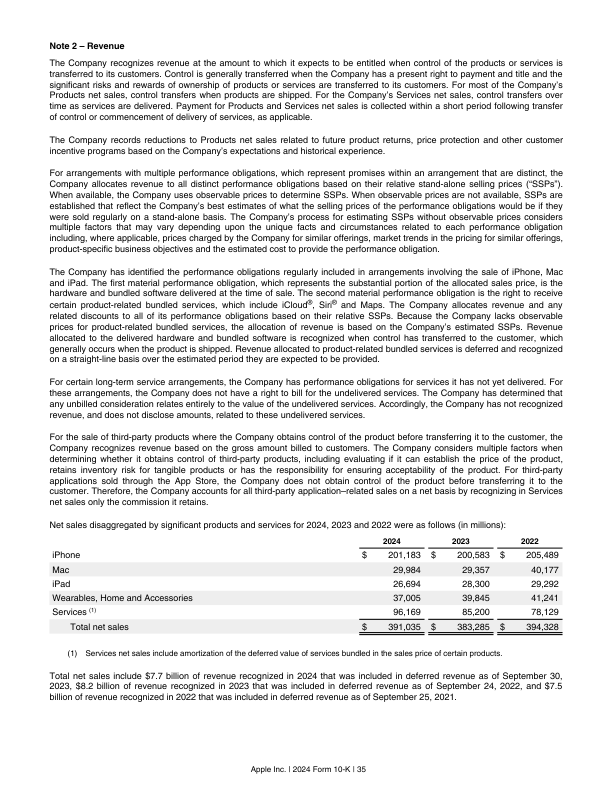

In [208]:
from IPython.display import Image as IPImage
from IPython.display import display

display(IPImage(data=base64.b64decode(page_image)))

In [209]:
query = "what is latest number for Net salesin 2024?"
answer, total_tokens_used = reader.run_multimodal_query(query, page_image)

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [210]:
print (answer)
print (f'Total Tokens used to generate this answer is {total_tokens_used}')

The latest number for net sales in 2024 is $391,035 million.
Total Tokens used to generate this answer is 894


In [211]:
# Asking another fact based query
query="what is latest value for Net Income?"
matching_chunk_index = reader.vector_search(query)
print (matching_chunk_index)
page_number = reader.get_pagenum_for_chunk(chunks,matching_chunk_index)
print (page_number)
page_image = reader.pdf_page_to_base64(page_number)
reader.run_multimodal_query(query, page_image)

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


166
31


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


('The latest value for Net Income for the year ended September 28, 2024, is $93,736 million.',
 898)

In [212]:
# Asking another fact based query
query="what is the revenue earned from products in 2024?"
matching_chunk_index = reader.vector_search(query)
print (matching_chunk_index)
page_number = reader.get_pagenum_for_chunk(chunks,matching_chunk_index)
print (page_number)
page_image = reader.pdf_page_to_base64(page_number)
reader.run_multimodal_query(query, page_image)

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


191
37


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


('The revenue earned from products in 2024 is $305,986 million.', 893)

In [193]:
# Asking another fact based query
query="what were the total operating expenses of the company in the latest annual financial report?"
matching_chunk_index = reader.vector_search(query)
print (matching_chunk_index)
page_number = reader.get_pagenum_for_chunk(chunks,matching_chunk_index)
print (page_number)
page_image = reader.pdf_page_to_base64(page_number)
reader.run_multimodal_query(query, page_image)
answer= reader.run_multimodal_query(query, page_image)
print(answer)
total_tokens_used = reader.run_multimodal_query(query, page_image)
print (f'Total Tokens used to generate this answer is {total_tokens_used}')

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


39
26


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


('The total operating expenses of the company in 2024 were $57,467 million.', 899)


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Total Tokens used to generate this answer is ('The total operating expenses for the company in the latest annual financial report (2024) were $57,467 million.', 905)


In [213]:
# Example Usage (assuming you have a Reader_10K instance called 'reader')
query = "hat were the total operating expenses of the company in the latest annual financial report?"
response_text, tokens_used = reader.run_text_based_query(query)
print(f"Question: {query}")
print(f"Answer: {response_text}")
print(f"Tokens Used: {tokens_used}")
print(page_number)

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Question: hat were the total operating expenses of the company in the latest annual financial report?
Answer: The total operating expenses of the company in the latest annual financial report were $57,467.
Tokens Used: 287
37
